In [8]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, roc_curve, roc_auc_score
from sklearn.model_selection import train_test_split
import shap
from matplotlib import pyplot as plt
from copy import deepcopy
import numpy as np
import pandas as pd
import pickle
%matplotlib inline

In [9]:
try:
    with open('dataset.pickle', 'rb') as f:
        print('Loaded cached dataset')
        X, y, display_data, feature_names, n_features, n_samples = pickle.load(f)
except FileNotFoundError:
    print('No cached dataset found')

Loaded cached dataset


In [10]:
try:
    with open('classifiers.pickle', 'rb') as f:
        clf_a, clf_b = pickle.load(f)
        print('Loaded cached models')
except FileNotFoundError:
    print('No cached models found')

Loaded cached models


In [11]:
try:
    with open('predictions.pickle', 'rb') as f:
        X_clean, display_data_clean, feature_names, n_features, n_samples_clean, indices, pred_a, pred_b, proba_a, proba_b, log_proba_a, log_proba_b, log_odds_a, log_odds_b = pickle.load(f)
        print('Loaded cached predictions')
except FileNotFoundError:
    print('No cached predictions found')

Loaded cached predictions


## Load Data

In [12]:
X, y = shap.datasets.adult()
display_data = shap.datasets.adult(display=True)[0].values
feature_names = np.array(X.columns)
n_features = len(feature_names)
n_samples = X.shape[0]
with open('dataset.pickle', 'wb') as f:
    pickle.dump((X, y, display_data, feature_names, n_features, n_samples), f, pickle.HIGHEST_PROTOCOL)

In [13]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, stratify=y, random_state=52)

## Train Models

TODO: https://scikit-learn.org/stable/modules/calibration.html

In [44]:
%%time
clf_a = LogisticRegression(C=1.0, max_iter=10000)
clf_a.fit(X_train, y_train)
clf_b = deepcopy(clf_a)
#clf_b.coef_[0, feature_names.tolist().index('Age')] -= 1e-3
clf_b.intercept_[0] -= 5e-2
with open('classifiers.pickle', 'wb') as f:
    pickle.dump((clf_a, clf_b), f, pickle.HIGHEST_PROTOCOL)

CPU times: user 13.3 s, sys: 1.08 s, total: 14.4 s
Wall time: 8.22 s


## Analyze Performance

In [45]:
pred_test_a = clf_a.predict(X_test)
pred_test_b = clf_b.predict(X_test)

In [46]:
print(classification_report(pred_test_a, y_test))

              precision    recall  f1-score   support

       False       0.94      0.87      0.90      5364
        True       0.54      0.73      0.62      1149

    accuracy                           0.84      6513
   macro avg       0.74      0.80      0.76      6513
weighted avg       0.87      0.84      0.85      6513



In [47]:
print(classification_report(pred_test_b, y_test))

              precision    recall  f1-score   support

       False       0.94      0.86      0.90      5414
        True       0.52      0.74      0.61      1099

    accuracy                           0.84      6513
   macro avg       0.73      0.80      0.76      6513
weighted avg       0.87      0.84      0.85      6513



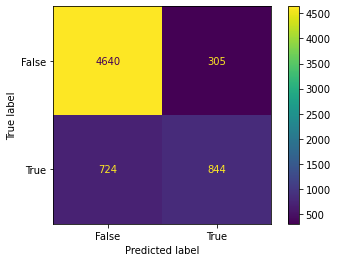

In [48]:
cm = confusion_matrix(y_test, pred_test_a, labels=clf_a.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=clf_a.classes_)
disp.plot();

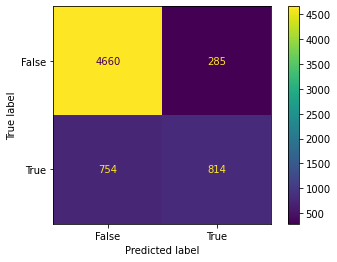

In [49]:
cm = confusion_matrix(y_test, pred_test_b, labels=clf_b.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=clf_b.classes_)
disp.plot();

In [50]:
proba_test_a = clf_a.predict_proba(X_test)[:, 1]
proba_test_b = clf_b.predict_proba(X_test)[:, 1]
fpr_a, tpr_a, _ = roc_curve(y_test, proba_test_a)
fpr_b, tpr_b, _ = roc_curve(y_test, proba_test_b)

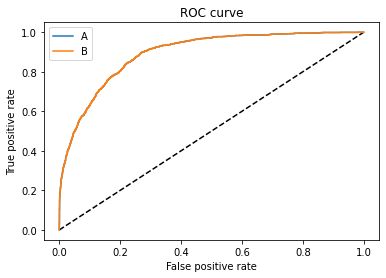

In [51]:
plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_a, tpr_a, label='A')
plt.plot(fpr_b, tpr_b, label='B')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

In [52]:
roc_auc_score(y_test, proba_test_a)

0.8920452141928562

In [53]:
roc_auc_score(y_test, proba_test_b)

0.892045214192856

## Visualize Distributions of Predictions

In [54]:
log_proba_a = clf_a.predict_log_proba(X)
log_proba_b = clf_b.predict_log_proba(X)
log_odds_a = log_proba_a[:, 1] - log_proba_a[:, 0]
log_odds_b = log_proba_b[:, 1] - log_proba_b[:, 0]

is_finite = np.isfinite(log_odds_a) & np.isfinite(log_odds_b)
X_clean = X[is_finite]
display_data_clean = display_data[is_finite]

n_samples_clean = X_clean.shape[0]
indices = np.array(range(n_samples_clean))
pred_a = clf_a.predict(X)
pred_b = clf_b.predict(X)
proba_a = clf_a.predict_proba(X)
proba_b = clf_b.predict_proba(X)
log_proba_a = clf_a.predict_log_proba(X)
log_proba_b = clf_b.predict_log_proba(X)
log_odds_a = log_proba_a[:, 1] - log_proba_a[:, 0]
log_odds_b = log_proba_b[:, 1] - log_proba_b[:, 0]

with open('predictions.pickle', 'wb') as f:
    pickle.dump((X_clean, display_data_clean, feature_names, n_features, n_samples_clean, indices, pred_a, pred_b, proba_a, proba_b, log_proba_a, log_proba_b, log_odds_a, log_odds_b), f, pickle.HIGHEST_PROTOCOL)

Instances with non-finite log-odds predictions:

In [56]:
pd.DataFrame(X[~is_finite]).describe()

,Age,Workclass,Education-Num,Marital Status,Occupation,Relationship,Race,Sex,Capital Gain,Capital Loss,Hours per week,Country
count,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
mean,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
std,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
min,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
25%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
50%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
75%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
max,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


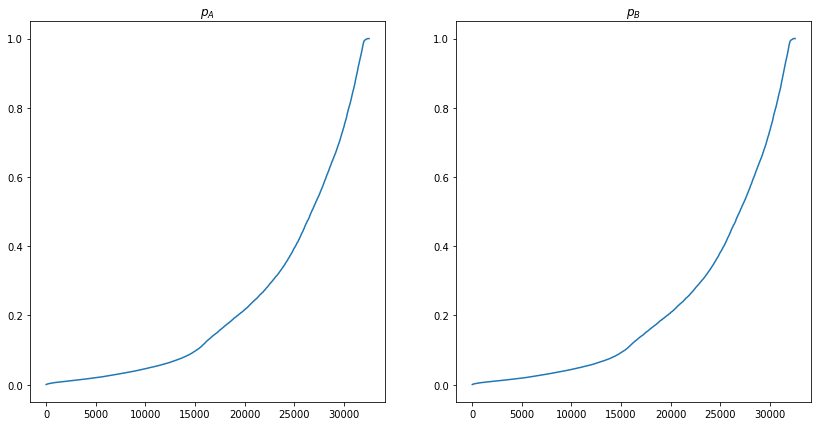

In [57]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(7*2, 7))
ax1.set_title('$p_A$')
ax1.plot(sorted(proba_a[:, 1]))
ax2.set_title('$p_B$')
ax2.plot(sorted(proba_b[:, 1]));

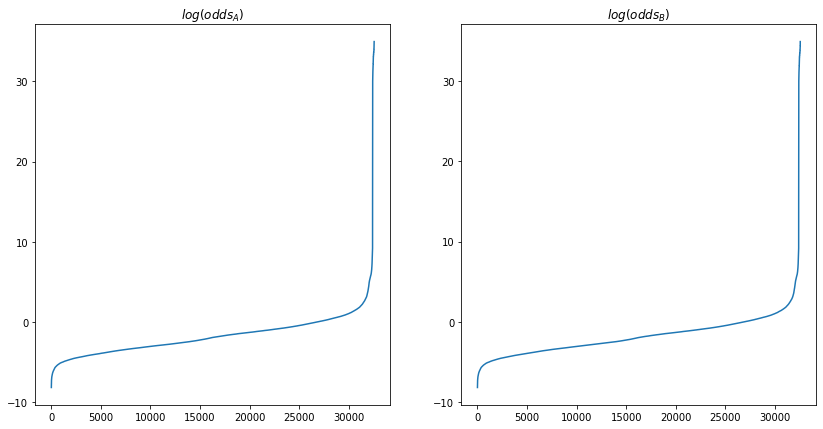

In [58]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(7*2, 7))
ax1.set_title('$log(odds_A)$')
ax1.plot(sorted(log_odds_a))
ax2.set_title('$log(odds_B)$')
ax2.plot(sorted(log_odds_b));

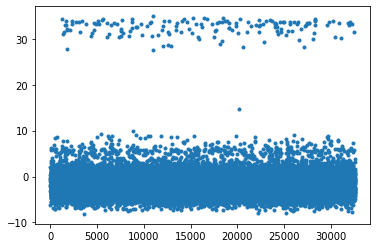

In [59]:
plt.scatter(indices, log_odds_a, marker='.');

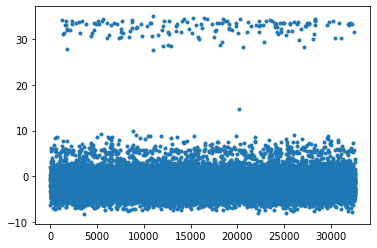

In [60]:
plt.scatter(indices, log_odds_b, marker='.');